In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *

# 讀檔

In [143]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def gen_total_mag(df: pd.DataFrame):
#     df['mag_x'] = moving_average(df['mag_x'], 1)
#     df['mag_y'] = moving_average(df['mag_y'], 1)
#     df['mag_z'] = moving_average(df['mag_z'], 1)
    
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    
    return df


def calculate_angle(df):
#     df['acc_x'] = moving_average(df['acc_x'], 1)
#     df['acc_y'] = moving_average(df['acc_y'], 1)
#     df['acc_z'] = moving_average(df['acc_z'], 1)

#     df['lin_acc_x'] = moving_average(df['lin_acc_x'], 1)
#     df['lin_acc_y'] = moving_average(df['lin_acc_y'], 1)
#     df['lin_acc_z'] = moving_average(df['lin_acc_z'], 1)
    
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    df['angle'] = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return df


def get_rotation_matrix(angle):
    pitch = 0
    roll = angle / 180 * np.pi
    yaw = 0
    p_m = [[np.cos(pitch), 0, np.sin(pitch)], [0, 1, 0], [-np.sin(pitch), 0, np.cos(pitch)]]
    y_m = [[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]]
    r_m = [[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]]
    
    p_m, y_m, r_m = np.array(p_m), np.array(y_m), np.array(r_m)
    rotation_matrix = p_m @ y_m @ r_m
    
    return rotation_matrix


def calculate_transform(row, column_name):
    R = get_rotation_matrix(row['angle'] - 45)
    new_row = R @ row[column_name]
    
    return new_row


def gen_45_mag(df):
    df[['mag_x', 'mag_y', 'mag_z']] = df.apply(lambda x: calculate_transform(x, ['mag_x', 'mag_y', 'mag_z']), axis=1, result_type='expand')
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    return df


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'angle', 'mag_x', 'mag_y', 'mag_z', 'mag_t', 'system_time']]


def load_original_data(path, rotate=False):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    total_df = gen_total_mag(total_df)
    total_df = calculate_angle(total_df)
    
    if rotate:
        total_df = gen_45_mag(total_df)
    total_df = select_data(total_df)
    
    return total_df

In [144]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, seq_len=25):
    num_of_segs = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * seq_len):int((i + 1) * seq_len)].to_numpy()
        segments.append(seg)
        
    return segments


def split_segments_overlap(df, seq_len=25, shift=15):
    
    segments = []
    for i in range(0, len(df) - seq_len, shift):
        seg = df.iloc[i:i + seq_len].to_numpy()
        segments.append(seg)
        
    return segments


def preprocess_data(df, seq_len=25, shift=15, is_train_data=False):
    if is_train_data:
        segs = split_segments_overlap(df, seq_len, shift)
    else:
        segs = split_segments(df, seq_len)
    
    return segs

In [145]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

#         print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    prefix = 'train' if is_train_data else 'valid'
    pair_data = []
    folder_paths = glob.glob(f'*{os.path.normpath(root_folder)}/*')

    if file_index is not None:
        folder_paths = folder_paths[file_index[0]:file_index[1]]

    for i, folder_path in enumerate(folder_paths):
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(f'{prefix} {i + 1: >3}: {folder_path}')
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path, rotate=False)
        target_df = load_original_data(target_path, rotate=True)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        source_df, target_df = align_data(source_df, target_df)

        source_segs = preprocess_data(source_df, seq_len, shift, is_train_data)
        target_segs = preprocess_data(target_df, seq_len, shift, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [146]:
datapoint_per_second = 20
duration = 2
seq_len = 25
shift = 15  # the shfit of the data
classes = {0: 'target', 1: 'front_pocket', 2: 'pocket', 3: 'swing'}

In [147]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [148]:
train_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[0, 8], is_train_data=True)
valid_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[8, 10], is_train_data=False)

train_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[0, 8], is_train_data=True)
valid_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[8, 10], is_train_data=False)

train_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[0, 8], is_train_data=True)
valid_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[8, 10], is_train_data=False)

train   1: front_pocket/202302071628
train   2: front_pocket/202302071652
train   3: front_pocket/202302071523
train   4: front_pocket/202302071531
train   5: front_pocket/202302071715
train   6: front_pocket/202302071641
train   7: front_pocket/202302071541
train   8: front_pocket/202302071619
valid   1: front_pocket/202302071704
valid   2: front_pocket/202302071724
train   1: pocket/202302132108
train   2: pocket/202302131750
train   3: pocket/202302131601
train   4: pocket/202302071606
train   5: pocket/202302132053
train   6: pocket/202302122132
train   7: pocket/202302132116
train   8: pocket/202302131643
valid   1: pocket/202301101952
valid   2: pocket/202302132101
train   1: swing/202302142339
train   2: swing/202302132131
train   3: swing/202302142117
train   4: swing/202302132124
train   5: swing/202302121947
train   6: swing/202302121857
train   7: swing/202302142128
train   8: swing/202302121920
valid   1: swing/202302121909
valid   2: swing/202302142331


In [149]:
print(len(train_front_pocket_pair_data), len(train_pocket_pair_data), len(train_swing_pair_data))
print(len(valid_front_pocket_pair_data), len(valid_pocket_pair_data), len(valid_swing_pair_data))

3070 3003 2900
462 395 416


In [150]:
def mse_loss(pred, target):
    return np.power(pred - target, 2)

In [151]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = np.mean(mse_loss(pred_mag, targ_mag))
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
#     pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
#     targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
#     plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
#     plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [229]:
def get_rotation_matrix(vec1, vec2):
    vec1 *= (np.sqrt(np.sum(vec2 ** 2)) / np.sqrt(np.sum(vec1 ** 2)))
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def recurrsive(smag, tmag, sgyro, tgyro):
    s = [np.diag(_) for _ in smag]
    t = [np.diag(_) for _ in tmag]
    C = get_rotation_matrix(smag[0], tmag[1])
    ans = []
    for idx, gyro in enumerate(sgyro[:]):
        tmp = np.dot(C, np.array(smag[idx]))
        tmp *= (np.sqrt(np.sum(smag[idx] ** 2)) / np.sqrt(np.sum(tmp ** 2)))
        ans.append(tmp)
        C = C @ (np.identity(3) + 0.05 * np.array([[0, -sgyro[idx][2], sgyro[idx][1]],
                                              [sgyro[idx][2], 0, -sgyro[idx][0]],
                                              [-sgyro[idx][1], sgyro[idx][0], 0]]
        ))
        
    return ans

In [230]:
data = train_pocket_pair_data[0]
recurrsive(data[0][:, 7:10], data[2][:, 7:10], data[0][:, 3:6], data[2][:, 3:6])

[array([-30.5144577 ,   3.39730087, -11.38801504]),
 array([-30.09414692,   1.69398718, -11.47709871]),
 array([-30.07900187,   1.6688675 , -10.37951445]),
 array([-30.18867834,   0.93484703, -10.12628132]),
 array([-30.85669986,   0.5323651 ,  -9.00491916]),
 array([-30.85023845,   0.15822564,  -8.70932007]),
 array([-31.25817916,   0.19801313,  -8.7616217 ]),
 array([-31.10668739,  -1.12340475,  -7.9901472 ]),
 array([-31.80085556,  -1.92607239,  -7.416644  ]),
 array([-31.98375039,  -3.21754463,  -7.53925101]),
 array([-32.63714587,  -3.41142567,  -5.66970083]),
 array([-33.36891399,  -3.82130306,  -3.6363765 ]),
 array([-34.31539961,  -2.98907763,  -1.48428192]),
 array([-34.11018352,  -4.73454701,  -2.43277196]),
 array([-34.59792248,  -4.47659558,  -0.36541617]),
 array([-33.25813153,  -3.92870535,   1.06267293]),
 array([-35.45044258,  -3.97477415,   2.40995016]),
 array([-36.56598788,  -3.64125714,   3.18027084]),
 array([-37.22870907,  -3.00615311,   3.68521279]),
 array([-37.

In [231]:
data[2][:, 7:10]

array([[-29.71944427,   3.49787434, -12.81816978],
       [-30.5144577 ,   3.39730087, -11.38801504],
       [-30.73630524,   2.20604716, -10.08848965],
       [-31.23067474,   3.51084458,  -8.13588945],
       [-31.52111053,   2.16079991,  -8.3065351 ],
       [-31.34500885,   1.13938603,  -8.14154752],
       [-31.04319   ,   1.88816798,  -7.98164405],
       [-31.10196686,   2.91278888,  -8.05147044],
       [-31.26117706,   3.72075284,  -7.66178796],
       [-31.28025055,   4.42909811,  -7.03975945],
       [-31.86615753,   4.59466058,  -6.48400745],
       [-31.62902069,   4.85876368,  -5.50167527],
       [-32.19109344,   5.04814186,  -5.61713228],
       [-32.06658173,   4.83542381,  -6.32996185],
       [-32.10326385,   6.01781699,  -5.55086153],
       [-32.24556732,   5.26230658,  -7.02207168],
       [-32.42966461,   5.07238412,  -6.72718999],
       [-32.45548248,   5.93762254,  -6.10611236],
       [-32.44176483,   6.39535261,  -6.62837029],
       [-32.38854218,   7.63816

In [232]:
loss = mse_loss(data[2][:, 7:10], recurrsive(data[0][:, 7:10], data[2][:, 7:10], data[0][:, 3:6], data[2][:, 3:6]))

In [233]:
np.mean(loss, axis=0)

array([ 9.41029436, 53.09697006, 34.24839248])

In [235]:
def eval_result(data):
    losses = []
    labels = []
    outputs = []
    
    for source_data, source_label, target_data, target_label in data:
        out_losses = []
        pred = []
        
        source_gyro = source_data[:, 3:6]
        source_mag = source_data[:, 7:10]
        
        target_gyro = target_data[:, 3:6]
        target_mag = target_data[:, 7:10]
        
        output = recurrsive(source_mag, target_mag, source_gyro, target_gyro)
        pred.append(output)

        loss = np.mean(mse_loss(output, target_mag), axis=0)

        out_losses.append(loss)
        
        pred = np.array(pred)
        
        losses.append(np.mean(out_losses, axis=0))
        labels.append(source_label)

        outputs.append([pred, target_mag, source_label])
        
    mean = np.mean(losses, axis=0)
    std = np.std(losses, axis=0)
    
    return mean, std, outputs

In [236]:
def static_result(data):
    mean, std, outs = eval_result(data)
    total_mean = np.mean(mean)
    
    print(f'loss x: {mean[0]:>6.2f} ± {std[0]:>6.2f},  y: {mean[1]:>6.2f} ± {std[1]:>6.2f},  z: {mean[2]:>6.2f} ± {std[2]:>6.2f},  all: {total_mean:>6.2f}')

In [237]:
print(f'front pocket: ', end='')
static_result(train_front_pocket_pair_data)

print(f'      pocket: ', end='')
static_result(train_pocket_pair_data)

print(f'       swing: ', end='')
static_result(train_swing_pair_data)

front pocket: loss x:  87.86 ± 266.82,  y:  88.61 ± 233.94,  z:  89.63 ± 208.56,  all:  88.70
      pocket: loss x:  99.37 ± 214.26,  y: 102.41 ± 176.64,  z: 109.03 ± 193.20,  all: 103.60
       swing: loss x: 110.14 ± 222.43,  y: 106.50 ± 190.33,  z: 116.78 ± 230.70,  all: 111.14


In [238]:
print(f'front pocket: ', end='')
static_result(valid_front_pocket_pair_data)

print(f'      pocket: ', end='')
static_result(valid_pocket_pair_data)

print(f'       swing: ', end='')
static_result(valid_swing_pair_data)

front pocket: loss x:  85.48 ± 225.76,  y:  95.64 ± 205.30,  z:  85.73 ± 167.47,  all:  88.95
      pocket: loss x: 125.94 ± 279.49,  y: 123.09 ± 208.02,  z: 127.07 ± 245.50,  all: 125.36
       swing: loss x: 110.23 ± 224.19,  y: 101.32 ± 156.62,  z: 124.74 ± 241.11,  all: 112.09


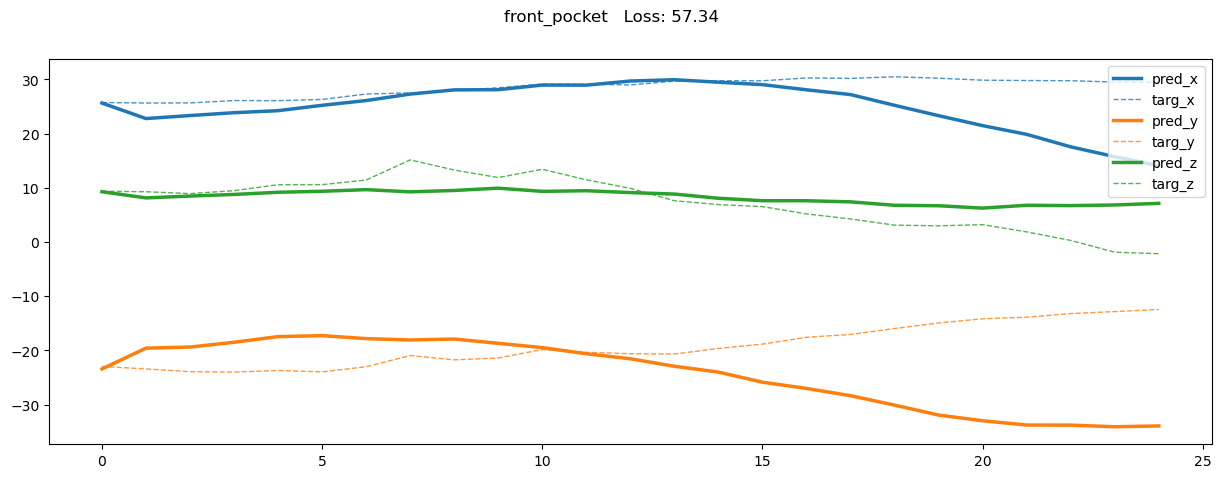

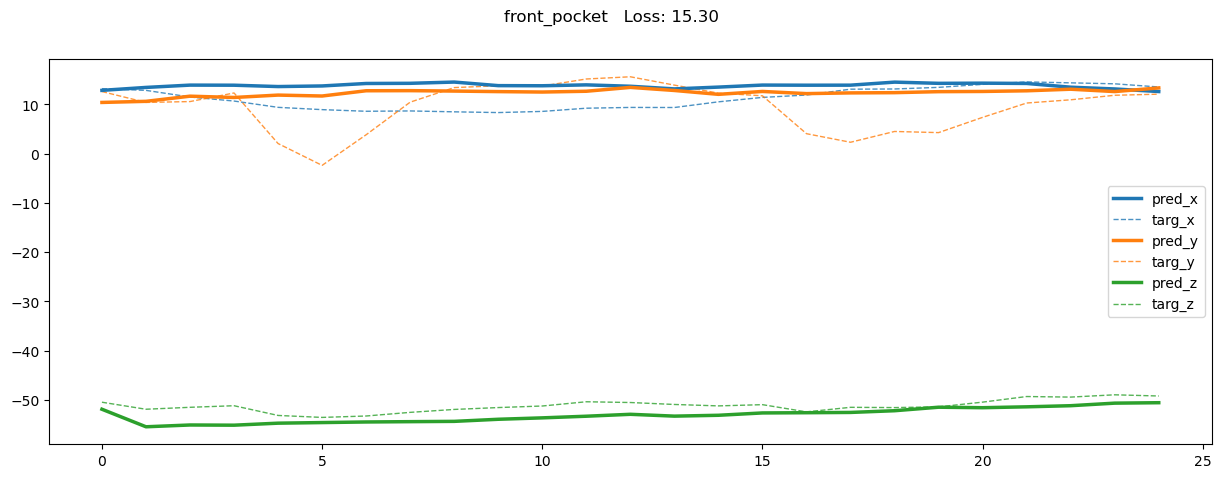

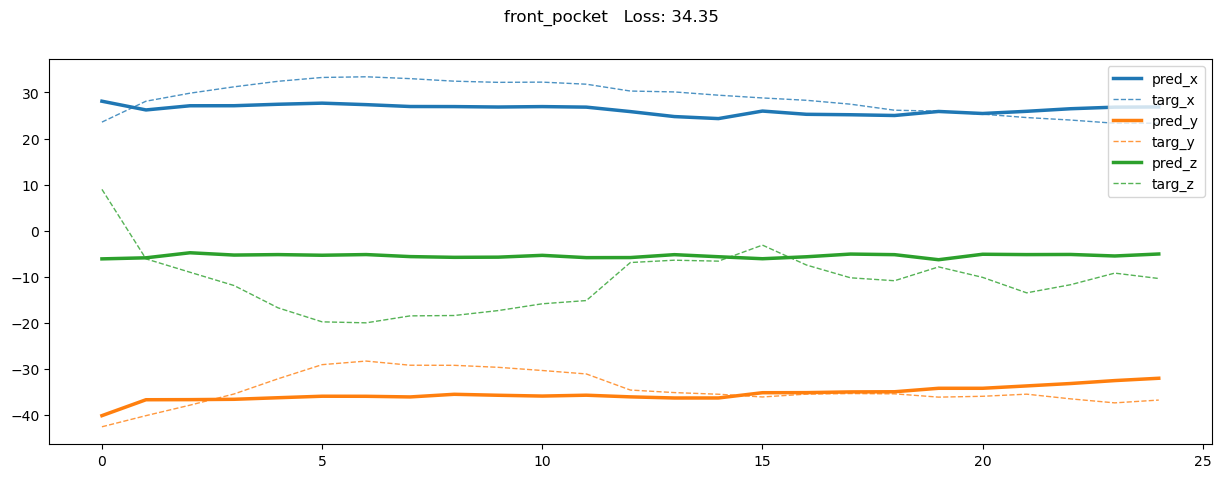

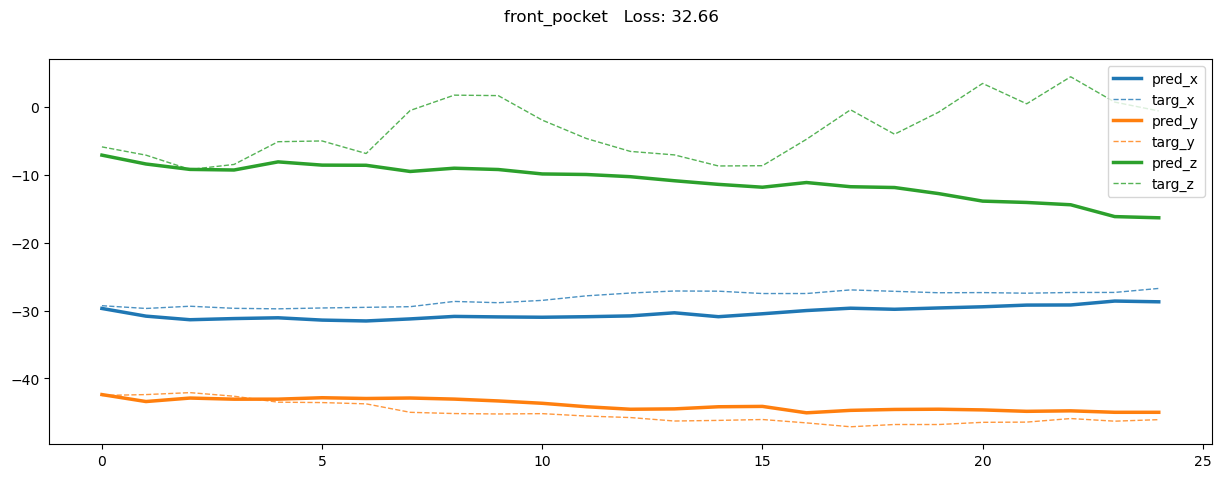

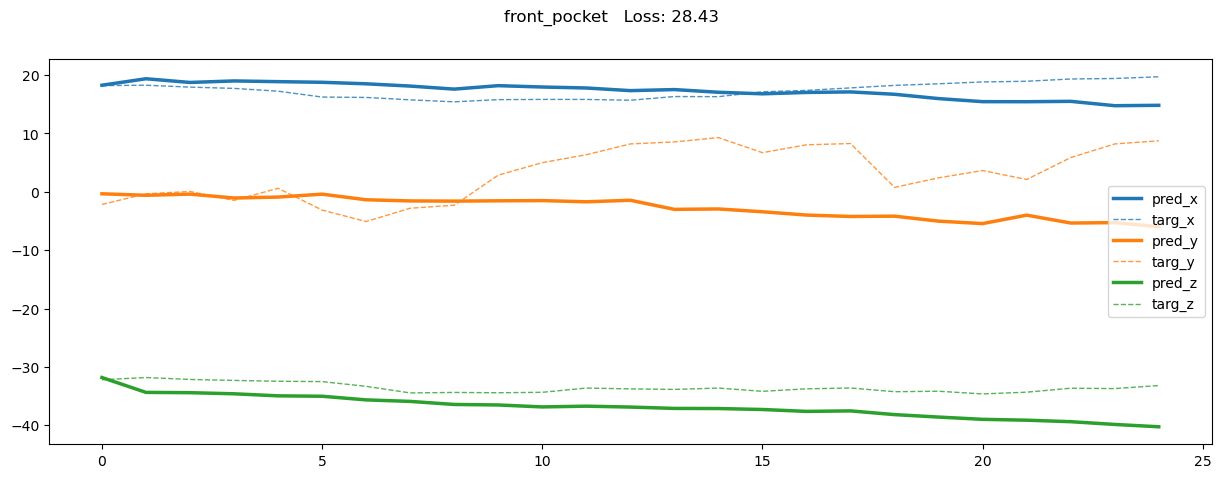

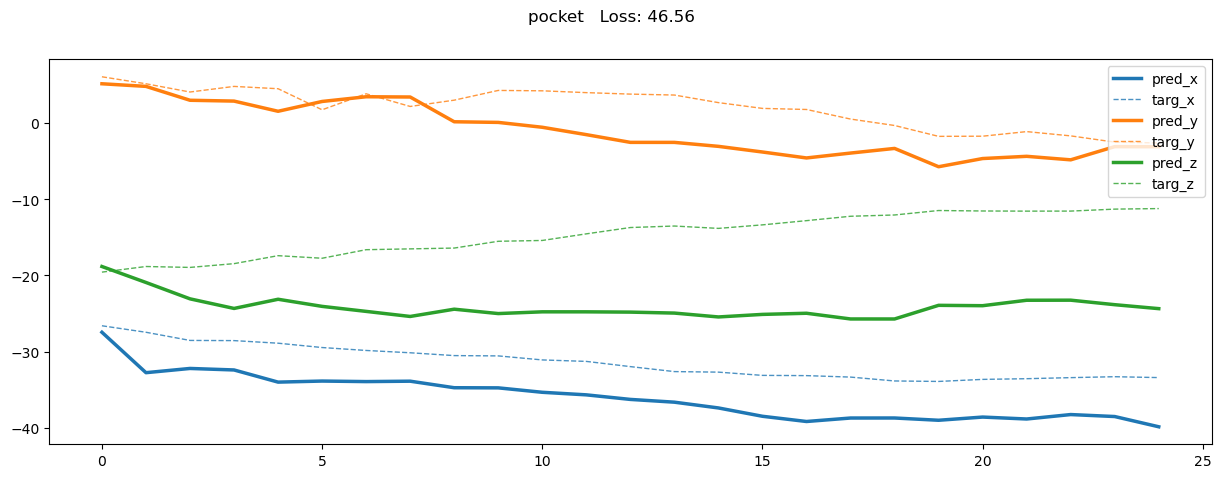

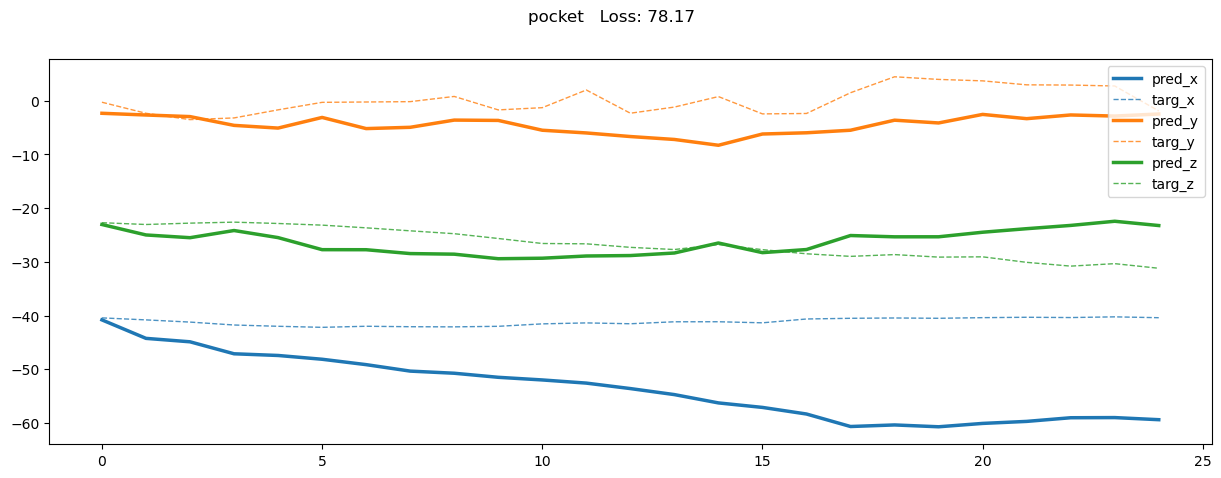

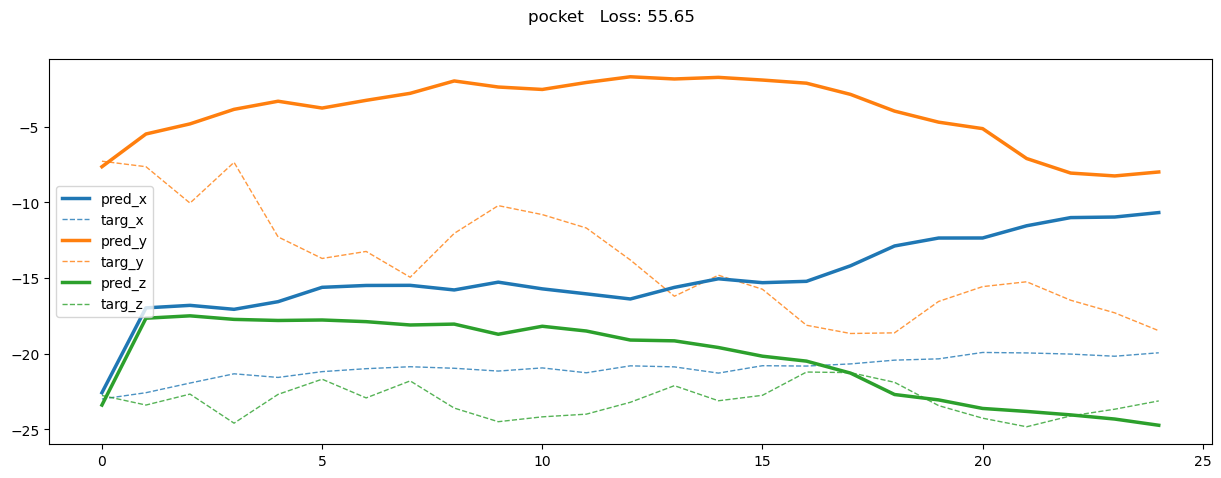

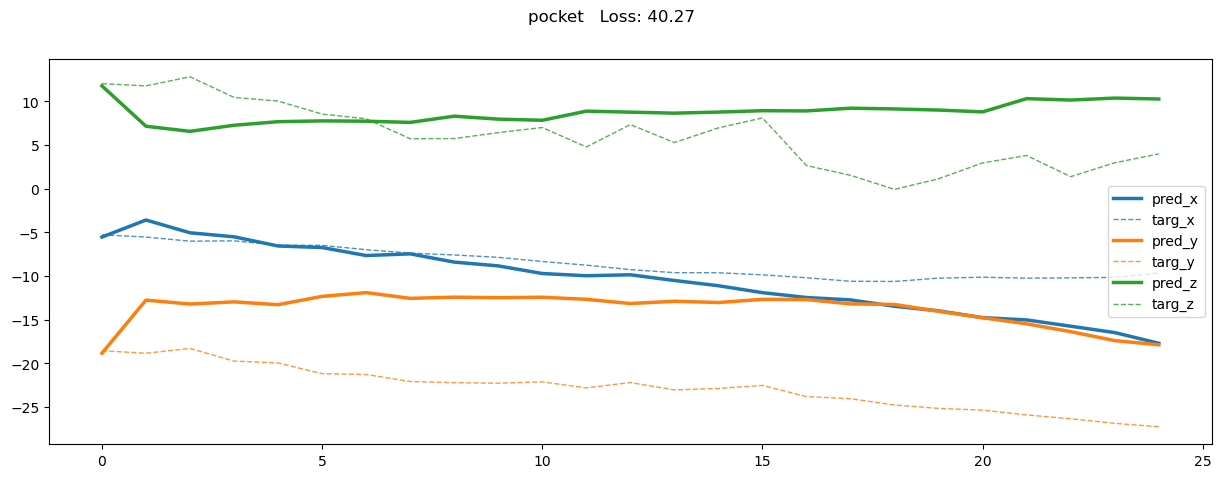

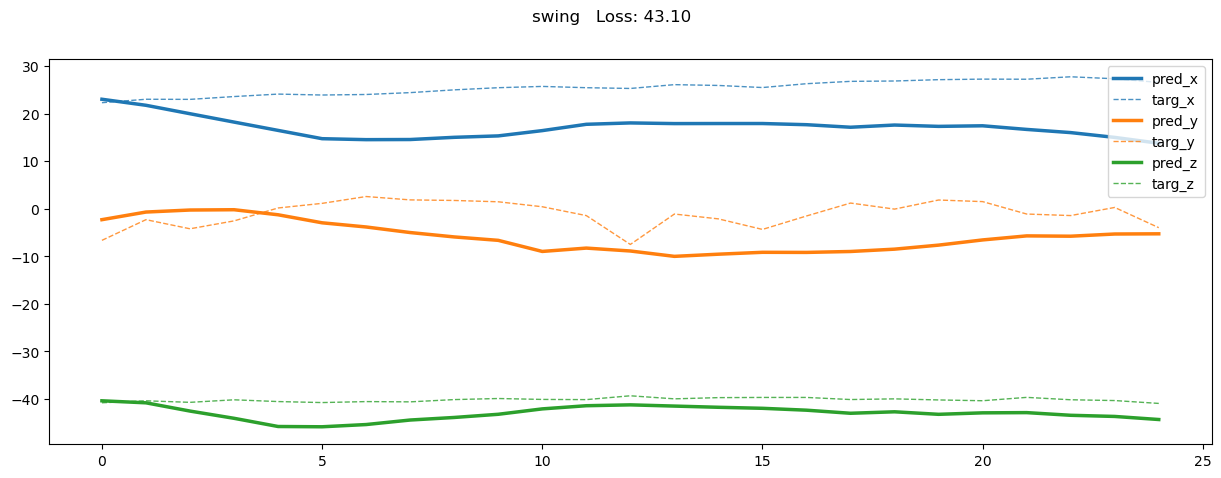

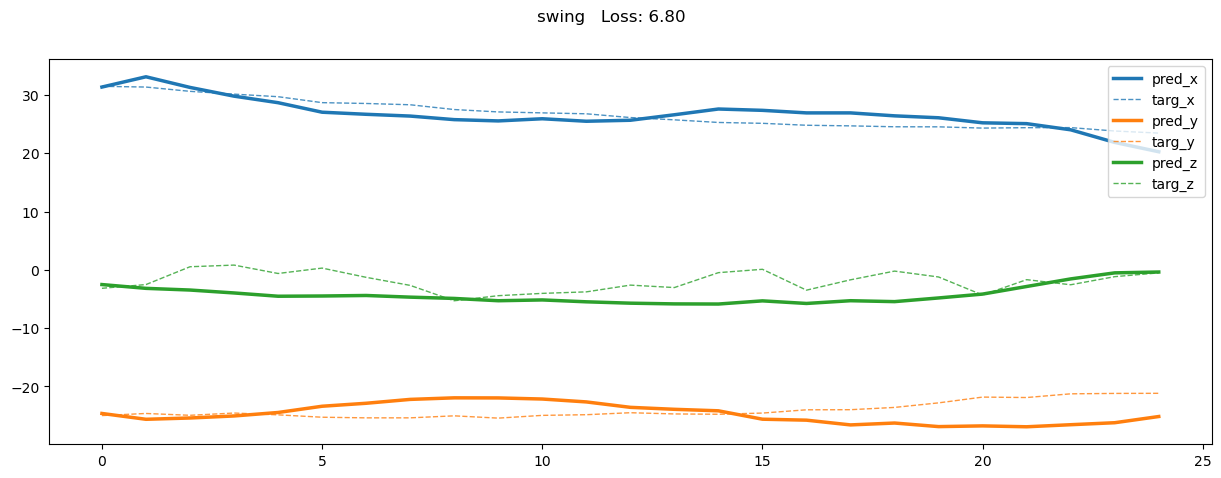

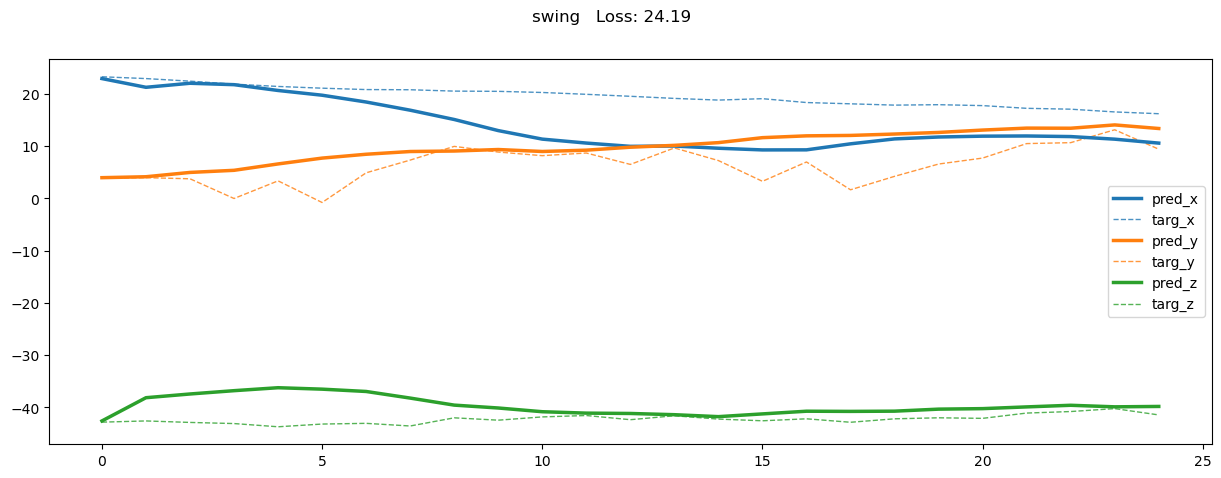

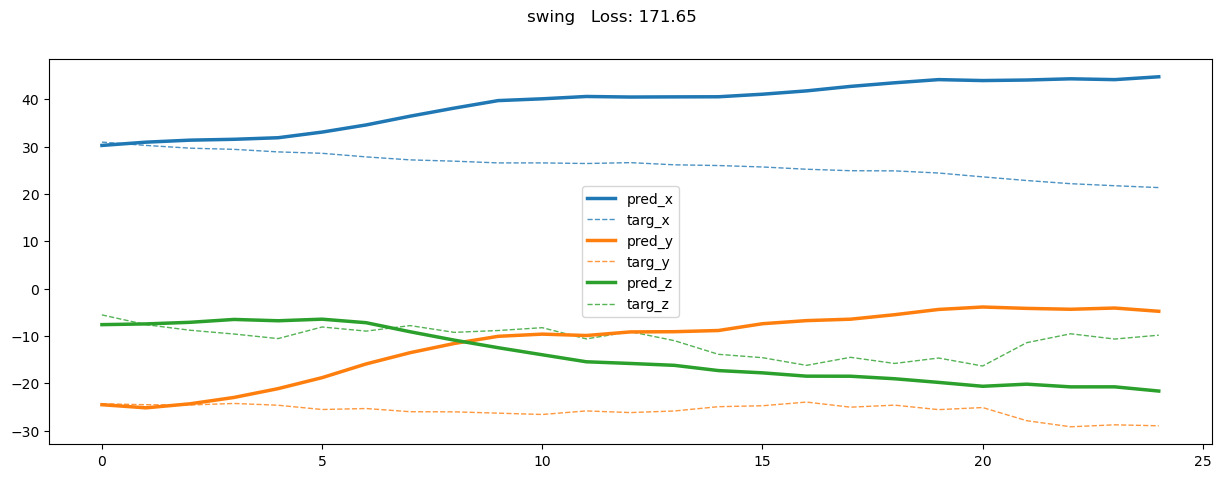

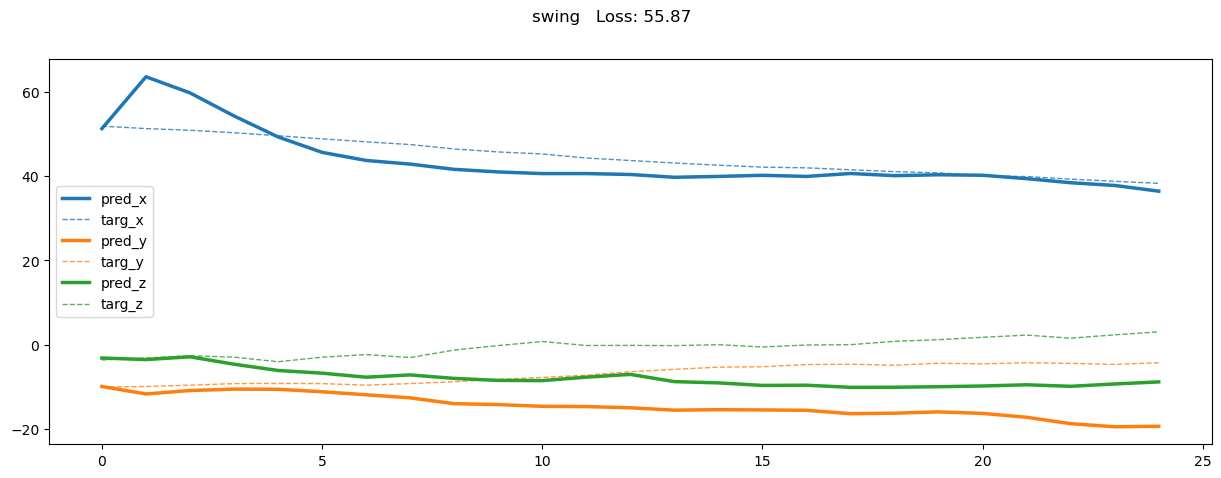

In [239]:
_, _, outs = eval_result(valid_front_pocket_pair_data)

for out in outs[::100]:
    plot_result(out)
    
_, _, outs = eval_result(valid_pocket_pair_data)

for out in outs[::100]:
    plot_result(out)
    
_, _, outs = eval_result(valid_swing_pair_data)

for out in outs[::100]:
    plot_result(out)